# Testing for File Permanence and Human Yes/No interface

In [6]:
import numpy as np
import pyvista as pv

from structgeo.model import geo
import structgeo.plot as geovis
from structgeo.model import history as geohistory
import structgeo.probability as rv
from structgeo.data.file_manager import FileManager

import importlib

pv.set_jupyter_backend('static')

In [7]:
def reloader():
    importlib.reload(geo)
    importlib.reload(geovis)
    importlib.reload(geohistory)
    importlib.reload(rv)
reloader()

## Goal:
Make an interaface that will present generated models with a yes/no decision to save the model

In [8]:
# Set random seed for reproducibility
# random_seed = 1234
# np.random.seed(random_seed)


Loading models from ../database/sedimentary_plane
Model loaded from ../database/sedimentary_plane\model_0.pkl
Model loaded from ../database/sedimentary_plane\model_1.pkl
Model loaded from ../database/sedimentary_plane\model_2.pkl
Model loaded from ../database/sedimentary_plane\model_3.pkl
Model loaded from ../database/sedimentary_plane\model_4.pkl


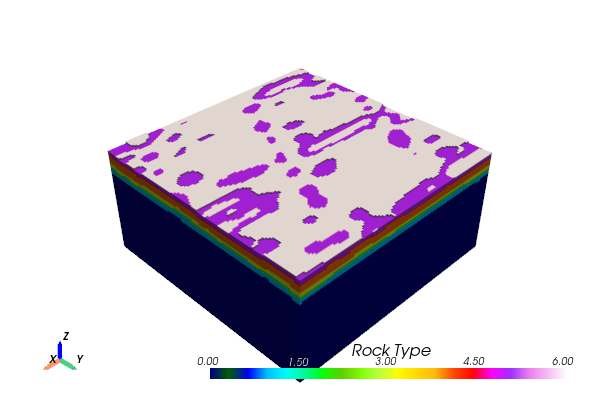

In [9]:
from structgeo.data.file_manager import FileManager

# Display the last saved model
fm = FileManager("../database/sedimentary_plane")
models = fm.load_all_models()
model = models[-1]
model.compute_model()
geovis.volview(model).show(window_size=[600, 400])

## Sedimentary Plane

In [10]:
from structgeo.data.model_reviewer import ModelReviewer

DEFAULT_BASE_DIR = "../database/sedimentary_plane"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

def generate_model():
    # Place the model generation logic here
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)
    height = min_x + model_size/2 + np.random.normal(1, model_size / 8)
    height = max(height, base + model_size/10)
    
    def thickness():
        avg_thickness = (height-base)/np.random.uniform(2, 15)
        return np.random.lognormal(np.log(avg_thickness), .1)
    
    bedrock = geo.Bedrock(base, 0)
    sediment = geo.Sedimentation(height, list(range(1, 100)), thickness_callable=thickness)
    
    # Add micro fold noise to the model
    def fold_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.04, .18),
            'periodic_func': rv.fourier_series_wave(num_harmonics=5)
        }
    sediment_noise = [geo.Fold(**fold_params()) for _ in range(np.random.randint(3, 7))]
    # Add macro fold noise to the model
    def fold_params2():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(30, 60),
            'amplitude': np.random.uniform(1.2),
            'periodic_func': None,
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]

    model.clear_history()
    model.add_history([bedrock, sediment] + sediment_noise + geo_noise)
    model.compute_model()
    return model


reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Model created with bounds (-10, 10) and resolution 128


Output()

Model saved to ../database/sedimentary_plane\model_5.pkl
Model saved!


Model discarded.


Model discarded.
